# Stage 2 - Data Pre-processing & Features Engineering
---

Kelompok 2:

*   Oei, Gabrielle Maureen B.S
*   Ummi Sarah
*   Arini Arumsari
*   Althaaf Athaayaa Daffa Qushayyizidane
*   Ruslan Hadi
*   Muhammad Ikhsan Hendriyana
*   Taufik Ismail
*   Jackson
*   Tsany Sutia

In [1]:
# Melakukan import library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import boxcox
from imblearn import under_sampling
import gdown
from sklearn.model_selection import train_test_split

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.23.5
pandas version :  2.0.2
seaborn version :  0.12.2


In [2]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [3]:
# Melakukan import csv
df = pd.read_csv("train.csv")
df.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
230397,230398,Male,48,1,8.0,0,1-2 Year,Yes,36694.0,124.0,192,1
340418,340419,Female,26,1,8.0,1,< 1 Year,No,42370.0,152.0,43,0
151050,151051,Male,33,1,29.0,0,< 1 Year,Yes,2630.0,156.0,76,1
280196,280197,Male,72,1,28.0,1,1-2 Year,No,64997.0,26.0,275,0
291720,291721,Male,41,1,28.0,1,1-2 Year,No,43987.0,124.0,259,0


In [4]:
# Pengelompokan kolom berdasarkan jenisnya
nums = ['int64', 'int32', 'int16', 'float64', 'float32', 'float16']
nums = df.select_dtypes(include=nums)
nums.drop(columns=['id'],inplace=True)
nums = nums.columns
cats = ['Gender','Vehicle_Age','Vehicle_Damage']

Target dari modelling classification ini adalah kolom **`Response`**.

# Data Cleansing (50 poin)

## Missing Value

In [5]:
# Melihat jumlah baris dan kolom
test = df.shape[0]

# Mengecek missing value ditiap fitur
missing_values_count = df.isnull().sum()
missing_values_count

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
# Melakukan pengecekan terhadap karakter tertentu yang mungkin termasuk NaN/NULL
value_to_find = ["-"," ",""]

value_found = False

for i, row in df.iterrows():
    for column in df.columns:
        if row[column] == value_to_find:
            print(f"Terdapat {value_to_find} di baris {i}, kolom {column}")
            value_found = True
            break
    if value_found:
        break

if not value_found:
    print(f"Tidak ditemukan")

Tidak ditemukan


Setelah dilakukan pengecekan terhadap NULL/NaN values, tidak terdapat NULL/NaN pada dataset.

## Duplicated data


In [7]:
df.duplicated().sum()

0

In [8]:
df.duplicated(subset=['id'],keep=False).sum()

0

Setelah dilakukan pengecekan terhadap duplicated values, tidak terdapat data duplikasi pada dataset.

## Outliers

Dari grafik yang kita keluarkan ketika EDA yang telah dilakukan di Stage 1, kita tahu `Annual Premium` memiliki outliers yang cukup extreme sehingga ditangani dengan penghapusan IQR ataupun capping.

In [9]:
# membuat function untuk mencari IQR
d = df.shape[0]
a = ['Annual_Premium']
def find_limit(df, variables) :
    q1 = df[variables].quantile(0.25)
    q3 = df[variables].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - (1.5 * iqr)
    upper_limit = q3 + (1.5 * iqr)
    return lower_limit, upper_limit

In [10]:
# Membuang value outliers
df_clean = df.copy()

for i in a :
    lower, upper = find_limit(df_clean, i)
    df_clean = df_clean[~((df_clean[i] < lower) | (df_clean[i] > upper))]

df_clean = df_clean.reset_index(drop = True)

print(f'Jumlah baris sebelum memfilter outlier: {d}')
print(f'Jumlah baris setelah memfilter outlier: {len(df_clean)}')
print(f'Sebanyak {d-len(df_clean)} rows dihapuskan atau {round(((d-len(df_clean))/d)*100,2)} %')

Jumlah baris sebelum memfilter outlier: 381109
Jumlah baris setelah memfilter outlier: 370789
Sebanyak 10320 rows dihapuskan atau 2.71 %


In [11]:
# Capping : Mengubah outlier value menjadi upper (atau) lower
df_cap = df.copy()

for i in a :
    lower, upper = find_limit(df_cap, i)
    df_cap.loc[(df_cap[i] > upper), i] = upper
    df_cap.loc[(df_cap[i] < lower), i] = lower

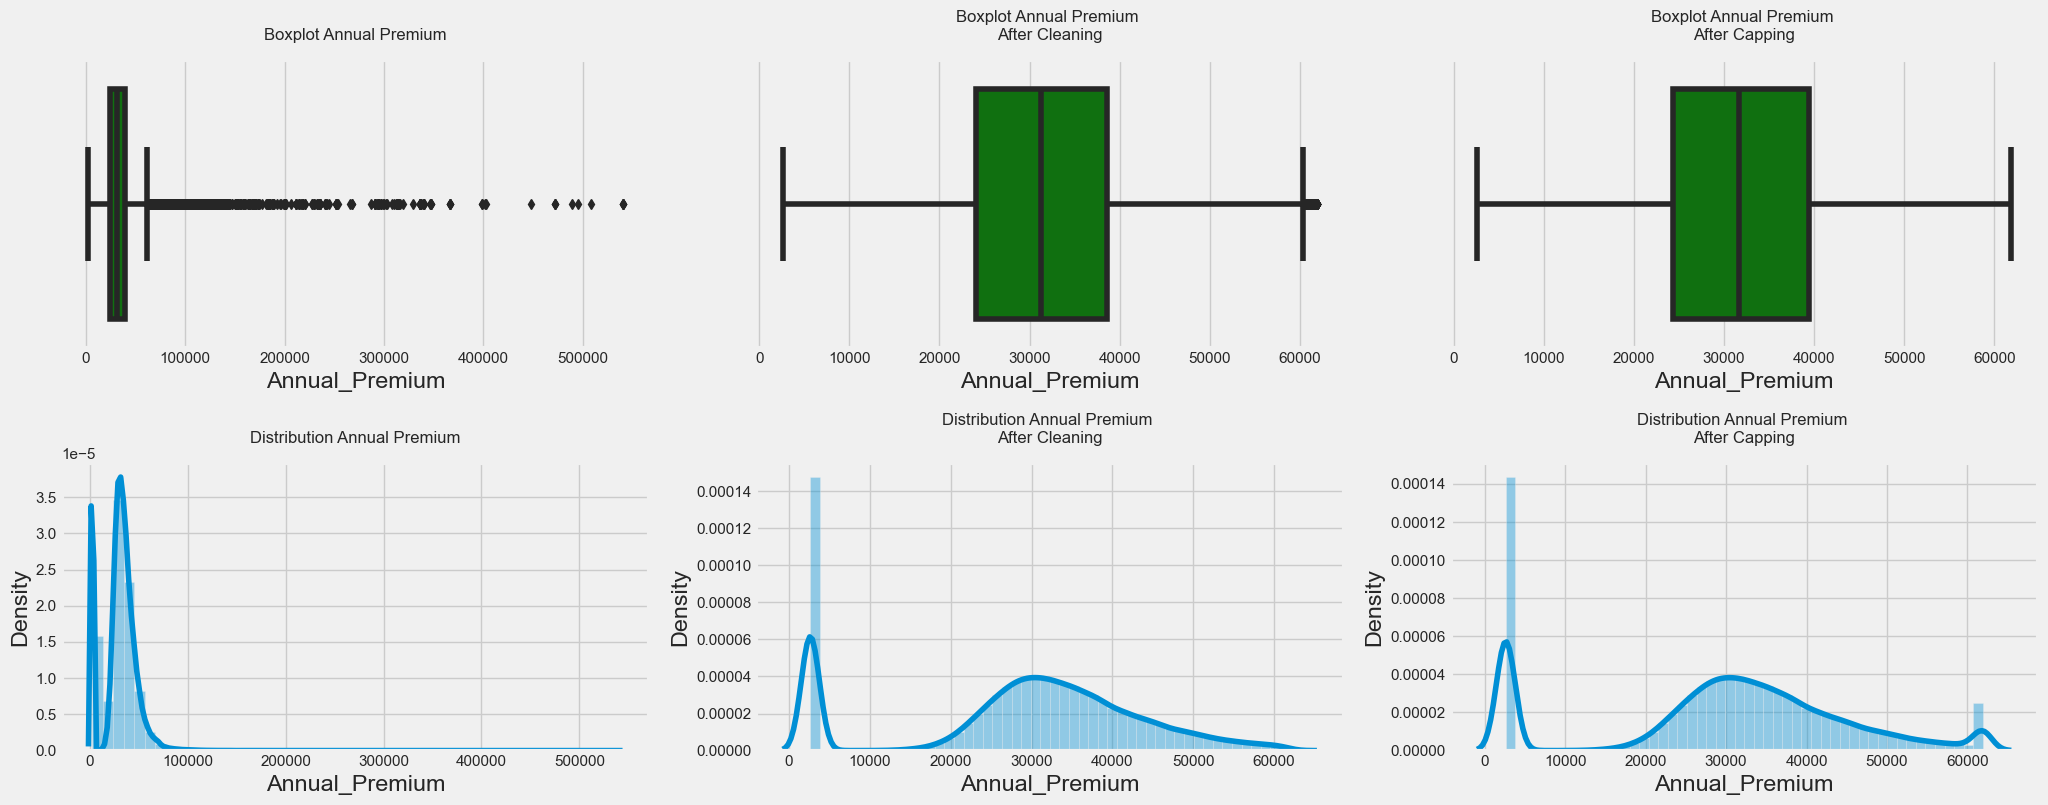

In [12]:
fig, ax = plt.subplots(2,3)

sns.boxplot(x=df['Annual_Premium'], color='green',orient='h',ax=ax[0,0])
ax[0,0].set_title('Boxplot Annual Premium', fontsize=12, pad=15, ha='center')
sns.distplot(df['Annual_Premium'], kde=True,ax=ax[1,0])
ax[1,0].set_title('Distribution Annual Premium', fontsize=12, pad=15, ha='center')

sns.boxplot(x=df_clean['Annual_Premium'], color='green',orient='h',ax=ax[0,1])
ax[0,1].set_title('Boxplot Annual Premium \nAfter Cleaning', fontsize=12, pad=15, ha='center')
sns.distplot(df_clean['Annual_Premium'], kde=True,ax=ax[1,1])
ax[1,1].set_title('Distribution Annual Premium \nAfter Cleaning', fontsize=12, pad=15, ha='center')

sns.boxplot(x=df_cap['Annual_Premium'], color='green',orient='h',ax=ax[0,2])
ax[0,2].set_title('Boxplot Annual Premium \nAfter Capping', fontsize=12, pad=15, ha='center')
sns.distplot(df_cap['Annual_Premium'], kde=True,ax=ax[1,2])
ax[1,2].set_title('Distribution Annual Premium \nAfter Capping', fontsize=12, pad=15, ha='center')

plt.tight_layout()

Diputuskan untuk tetap menggunakan dataframe df karena, kolom `Annual_Premium` merupakan hal yang normal jika terdapat outliers sehingga tidak dilakukan penghapusan outliers.

## Feature encoding

Mengubah `Vehicle_Damage` ke integer dalam = 0: Kendaraan customer belum pernah rusak, 1: Kendaraan customer sudah pernah rusak, serta `Vehicle_Age` dam 0: < 1 Year, 1: 1-2 Years, 2: > 2 Years. Melakukan konversi ke angka mulai dari 0 untuk memudahkan kerja machine learning. Mengubah kolom dengan datatype bool ke int agar lebih mudah diproses oleh model.

In [13]:
for i in ['Gender']:
    onehots = pd.get_dummies(df['Gender'], prefix='Gen')
    df = df.join(onehots)

df[['Gen_Female','Gen_Male']] = df[['Gen_Female','Gen_Male']].astype(int)

In [14]:
mapping_damage = {'Yes' : 1, 'No' : 0}
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(mapping_damage)


In [15]:
mapping_age = {'> 2 Years' : 2, '1-2 Year' : 1, '< 1 Year' : 0}
df['Vehicle_Age'] = df['Vehicle_Age'].map(mapping_age)

In [16]:
df.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gen_Female,Gen_Male
0,1,Male,44,1,28.0,0,2,1,40454.0,26.0,217,1,0,1
1,2,Male,76,1,3.0,0,1,0,33536.0,26.0,183,0,0,1


## Class Imbalance

In [17]:
# Melihat berapa dejarat ketimpangan pada class

for i in range(len(df['Response'].value_counts())):
    a = round(df['Response'].value_counts()[i]/df.shape[0]*100,2)
    print(f'{a}%')

print('Degree of Imbalance dari data ini termasuk pada Moderate Imbalance')

87.74%
12.26%
Degree of Imbalance dari data ini termasuk pada Moderate Imbalance


In [18]:
# Membuat kolom baru untuk melihat Class 'Yes'

df['Res_class'] = df['Response']==1
df['Res_class'].value_counts()

Res_class
False    334399
True      46710
Name: count, dtype: int64

In [19]:
# Memisahkan dataframe dengan Response dan Res_class dan hanya Res_class
X = df[[col for col in df.columns if (str(df[col].dtype) != 'object') and col not in ['Response', 'Res_class']]]
y = df['Res_class'].values
print(X.shape)
print(y.shape)

(381109, 12)
(381109,)


In [20]:
X_under_SMOTE, y_under_SMOTE = under_sampling.RandomUnderSampler(sampling_strategy=1, random_state=42).fit_resample(X, y)

In [21]:
print('Original')
print(pd.Series(y).value_counts())
print('\n')
print('UNDERSAMPLING')
print('SMOTE')
print(pd.Series(y_under_SMOTE).value_counts())

Original
False    334399
True      46710
Name: count, dtype: int64


UNDERSAMPLING
SMOTE
False    46710
True     46710
Name: count, dtype: int64


In [22]:
X_under_SMOTE['Response'] = y_under_SMOTE.astype(int)
df = X_under_SMOTE.copy()

# Feature Engineering

## Feature Selection

## Feature Extraction

## 4 New Features

## Feature Transformation

Data memiliki karakteristik mayoritas sudah berbentuk Gaussian namun ada beberapa yang masih belum tersebar normal.

In [26]:
# Mengkelompokkan kolom-kolom yang akan menjadi features serta target
x = ['int64', 'int32', 'int16', 'float64', 'float32', 'float16']
x = df.select_dtypes(include=x)
x.drop(columns=['Response'],inplace=True)
y = df['Response']

In [27]:
# Melakukan split test and train
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=1/3, random_state=42)

# Menggabungkan kembali features dan target untuk membuat dataframe test dan train

df_train = Xtrain.join(ytrain)
df_test  = Xtest.join(ytest)

Dari seluruh kolom yang bukan merupakan kolom kategori adalah `Age`, `Annual_Premium` dan `Vintage` sehingga hanya ketiga kolom ini yang dilakukan transformasi.

In [28]:
f_log = ['Age']
for i in f_log:
    df_train['log_'+i] = np.log(df_train[i] + (df_train[df_train[i] > 0][i].min() / 2))
    df_test['log_'+i] = np.log(df_test[i] + (df_test[df_test[i] > 0][i].min() / 2))

In [29]:
sscale = ['Annual_Premium','Vintage']

# Melakukan Standardization menggunakan Boxcox()
for i in sscale:
    df_train['nml_'+i],_ = boxcox(df_train[i]+1)
    df_test['nml_'+i],_ = boxcox(df_test[i]+1)

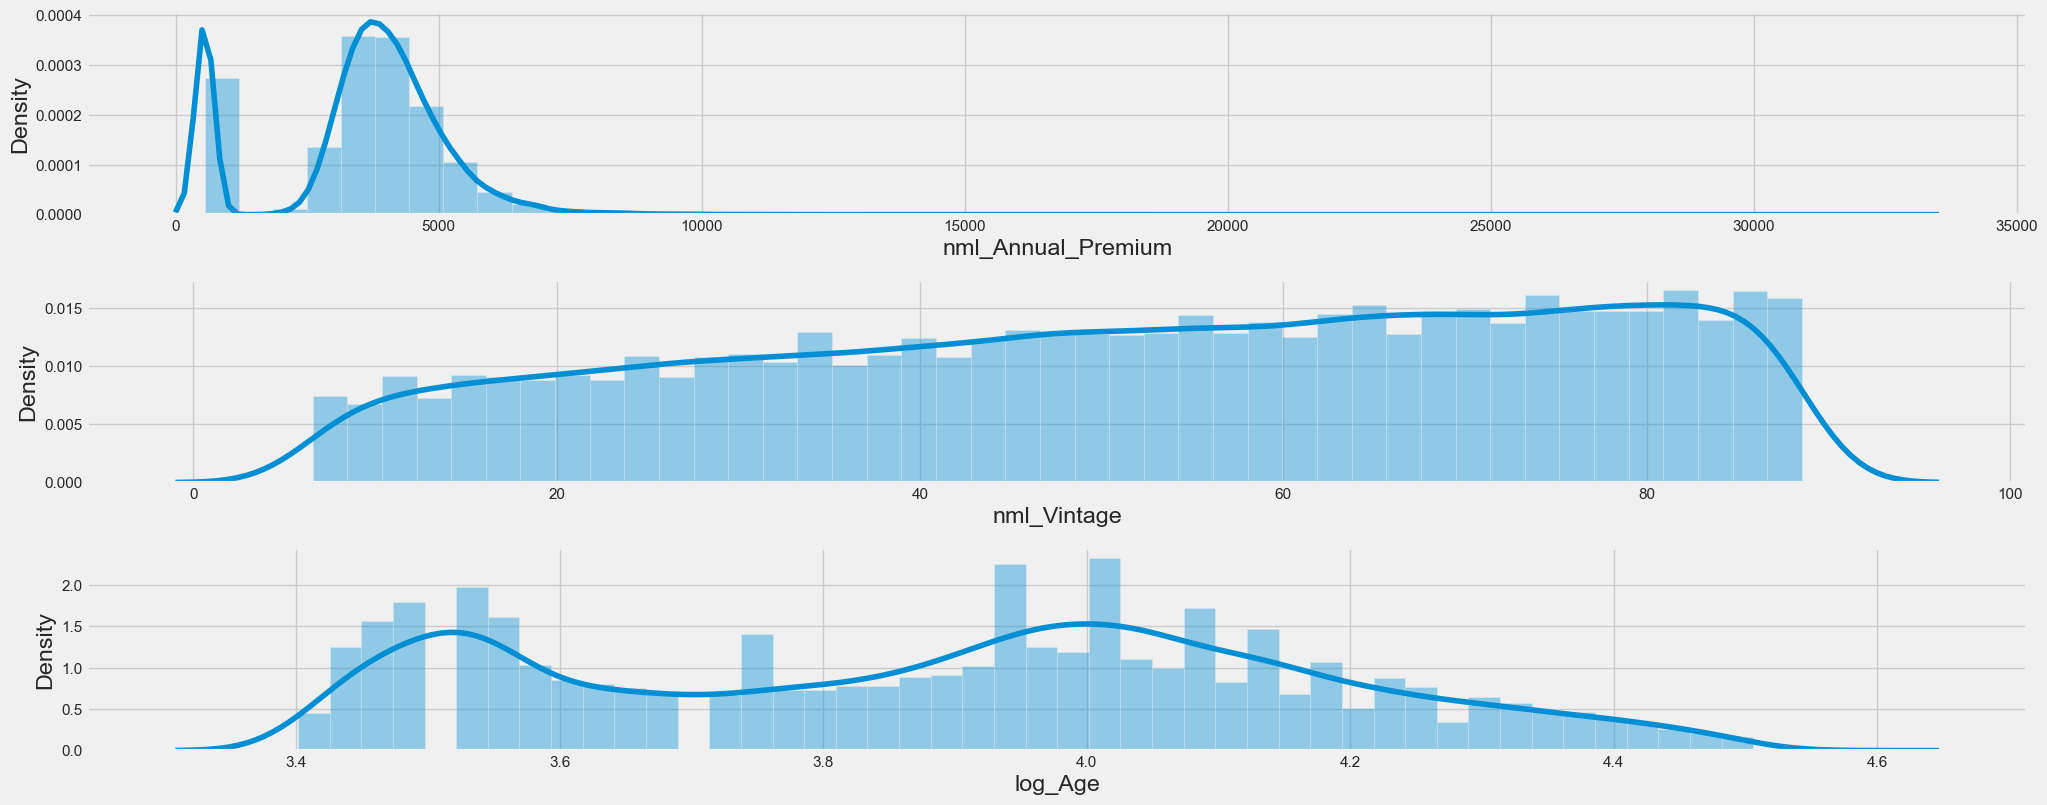

In [30]:
nums_std = ['nml_Annual_Premium', 'nml_Vintage', 'log_Age']

k = int((len(nums_std)+2)/3)

for i in range(0, len(nums_std)):
    plt.subplot(3, k, i+1)
    sns.distplot(df_train[nums_std[i]], kde=True)
    plt.tight_layout()

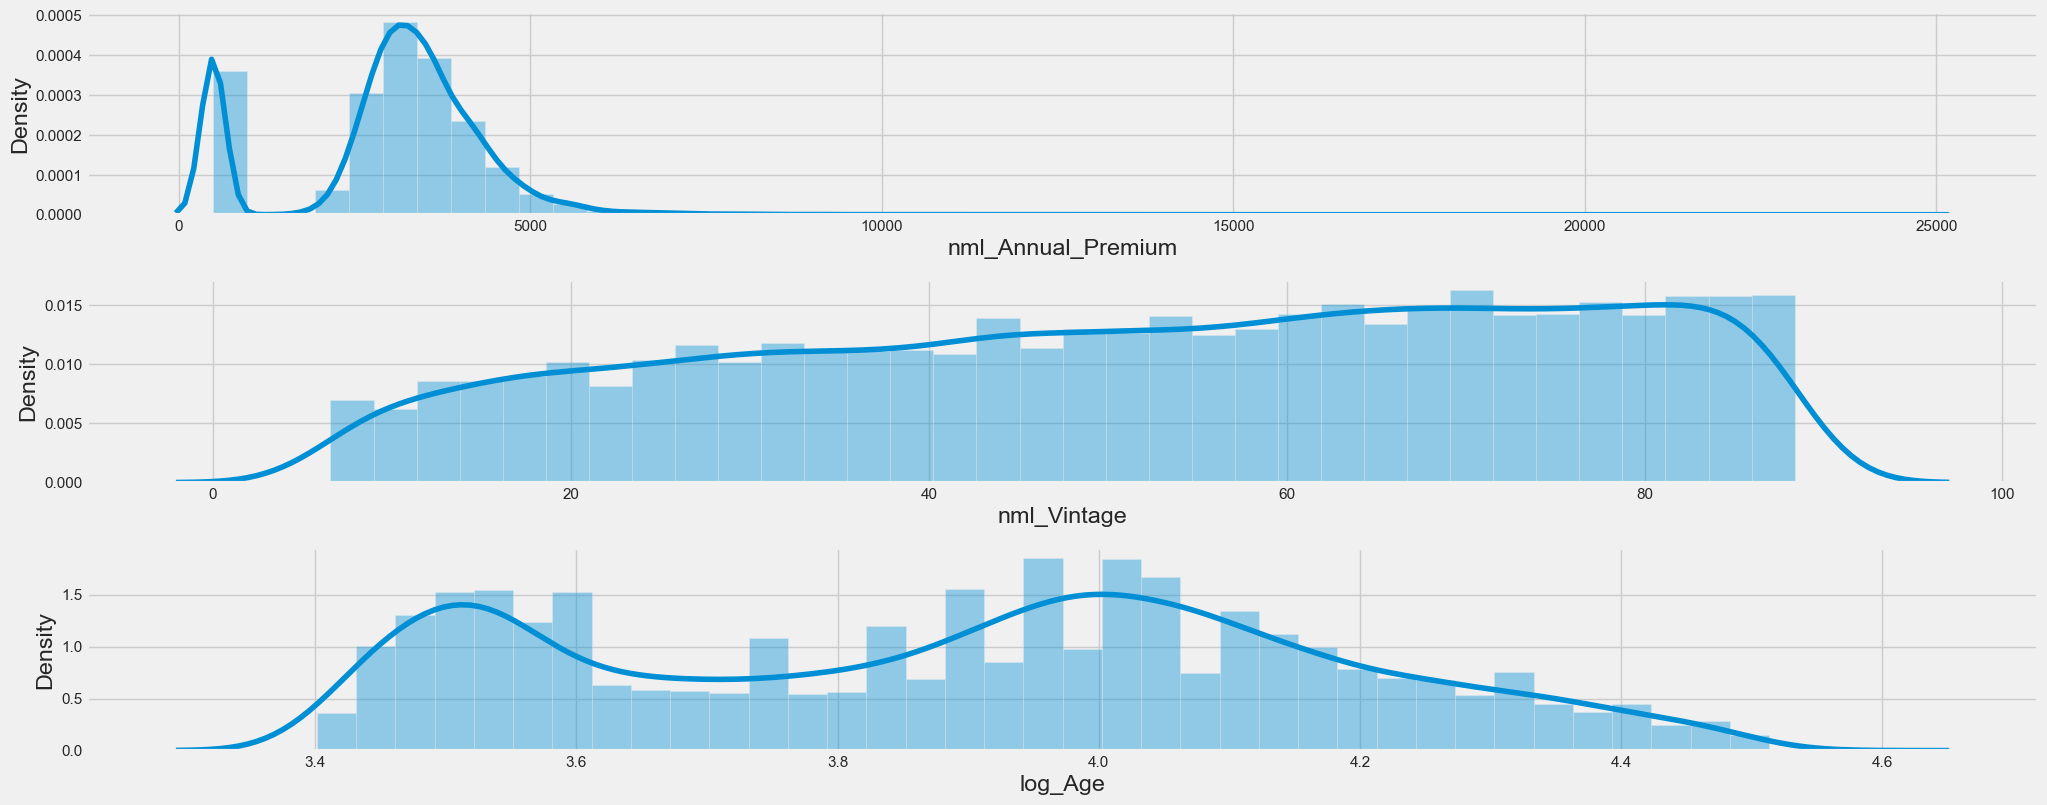

In [31]:
k = int((len(nums_std)+2)/3)

for i in range(0, len(nums_std)):
    plt.subplot(3, k, i+1)
    sns.distplot(df_test[nums_std[i]], kde=True)
    plt.tight_layout()

Diputuskan menggunakan `boxcox` dimana sebaran cenderung lebih normal.